In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd drive/My\ Drive/Projects/TimeSeriesForecasting

/content/drive/My Drive/Projects/TimeSeriesForecasting


In [0]:
import os
import json
import numpy as np
import pandas as po
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [0]:
from keras import optimizers
from keras.models import Model, Sequential
from keras.layers import ConvLSTM2D, Dense, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [0]:
os.makedirs('forecasts', exist_ok=True)
os.makedirs('forecasts/full_testing_length', exist_ok=True)
os.makedirs('forecasts/1_day_at_a_time', exist_ok=True)

In [0]:
df = po.read_csv('data/2017_energy_5min_noTransform.csv')

In [0]:
scaler = MinMaxScaler()
df['W'] = scaler.fit_transform(df)

In [0]:
class Args:
  def __init__(self):
    self.val_start = 12*24*250
    self.test_start = 12*24*300
    self.train_seq_len = 12*24*7
    self.val_seq_len = 12*24
    
    self.batch_size = 512
    self.num_epochs = 100
    self.save_folder = 'convLSTM'
    
    self.subsequences = self.train_seq_len//(12*24)
    self.conv_num_channels = 128
    self.kernel_size = (1, 12)

In [0]:
args = Args()

In [0]:
os.makedirs('forecasts/full_testing_length/' + args.save_folder, exist_ok=True)
os.makedirs('forecasts/1_day_at_a_time/' + args.save_folder, exist_ok=True)
os.makedirs('forecasts/1_day_at_a_time/' + args.save_folder + '/plots', exist_ok=True)
os.makedirs('forecasts/1_day_at_a_time/' + args.save_folder + '/tabulated_results', exist_ok=True)

In [0]:
train_df = df[: args.val_start]
val_df = df[args.val_start: args.test_start]
test_df = df[args.test_start:]

In [0]:
def make_windows(data, train_seq_len = args.train_seq_len, val_seq_len = args.val_seq_len):
    X = []
    y = []

    for i in tqdm(range(train_seq_len, len(data) - val_seq_len + 1)):    
        X.append(data.values[i - train_seq_len: i].T.tolist())
        y.append(data.values[i: i + val_seq_len].T.tolist())

    X = np.array(X).squeeze().reshape(-1, train_seq_len, 1)
    y = np.array(y).squeeze()

    return X, y

In [0]:
X_train, y_train = make_windows(train_df)

100%|██████████| 69697/69697 [00:10<00:00, 6401.17it/s]


In [0]:
X_val, y_val = make_windows(val_df)

100%|██████████| 12097/12097 [00:01<00:00, 8812.59it/s]


In [0]:
X_train = X_train.reshape(X_train.shape[0], args.subsequences, 1, -1, 1)
X_train.shape

(69697, 7, 1, 288, 1)

In [0]:
X_val = X_val.reshape(X_val.shape[0], args.subsequences, 1, -1, 1)
X_val.shape

(12097, 7, 1, 288, 1)

In [0]:
model = Sequential()
model.add(ConvLSTM2D(filters = args.conv_num_channels, kernel_size = args.kernel_size, activation = 'relu', input_shape = (args.subsequences, 1, X_train.shape[3], 1)))
model.add(Flatten())
model.add(Dense(args.val_seq_len))

In [0]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_2 (ConvLSTM2D)  (None, 1, 277, 128)       793088    
_________________________________________________________________
flatten_2 (Flatten)          (None, 35456)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 288)               10211616  
Total params: 11,004,704
Trainable params: 11,004,704
Non-trainable params: 0
_________________________________________________________________


In [0]:
best_epoch = 63 #load this epoch (performance across epochs measured in respective model training notebook) 
model.load_weights('model_checkpoints/' + args.save_folder + '/model_{:02d}.h5'.format(best_epoch))
best_epoch

63

In [0]:
X_test, y_test = make_windows(test_df)

100%|██████████| 12097/12097 [00:01<00:00, 8607.07it/s]


In [0]:
X_test = X_test.reshape(X_test.shape[0], args.subsequences, 1, -1, 1)
X_test.shape

(12097, 7, 1, 288, 1)

In [0]:
y_pred = model.predict(X_test)

In [0]:
for i in tqdm(range(y_pred.shape[0]//288)): ## we have forecasts for these many complete day
  plt.plot(scaler.inverse_transform(y_test[12*24*i].reshape(-1, 1)), color = 'blue')
  plt.plot(scaler.inverse_transform(y_pred[12*24*i].reshape(-1, 1)), color = 'red')
  plt.legend(['Actual Value', 'Prediction'])
  plt.savefig('forecasts/1_day_at_a_time/' + args.save_folder + '/plots/day_{}.png'.format(i))
  plt.close()

  df_t = po.DataFrame()
  df_t['Predictions'] = scaler.inverse_transform(y_pred[12*24*i].reshape(-1, 1)).reshape(-1)
  df_t['Actual_Values'] = scaler.inverse_transform(y_test[12*24*i].reshape(-1, 1)).reshape(-1)

  df_t.to_csv('forecasts/1_day_at_a_time/' + args.save_folder + '/tabulated_results/day_{}.csv'.format(i), index = False)

100%|██████████| 42/42 [00:05<00:00,  7.85it/s]


In [0]:
forecasts = []
actuals = []
for i in tqdm(range(y_pred.shape[0]//288)): ## we have forecasts for these many complete day
  forecasts += (scaler.inverse_transform(y_pred[12*24*i].reshape(-1, 1)).reshape(-1)).tolist()
  actuals += (scaler.inverse_transform(y_test[12*24*i].reshape(-1, 1)).reshape(-1)).tolist()

100%|██████████| 42/42 [00:00<00:00, 3388.88it/s]


In [0]:
df = po.DataFrame()
df['Predictions'] = forecasts
df['Actual Values'] = actuals

In [0]:
df.to_csv('forecasts/full_testing_length/' + args.save_folder + '/full_results.csv', index = False)

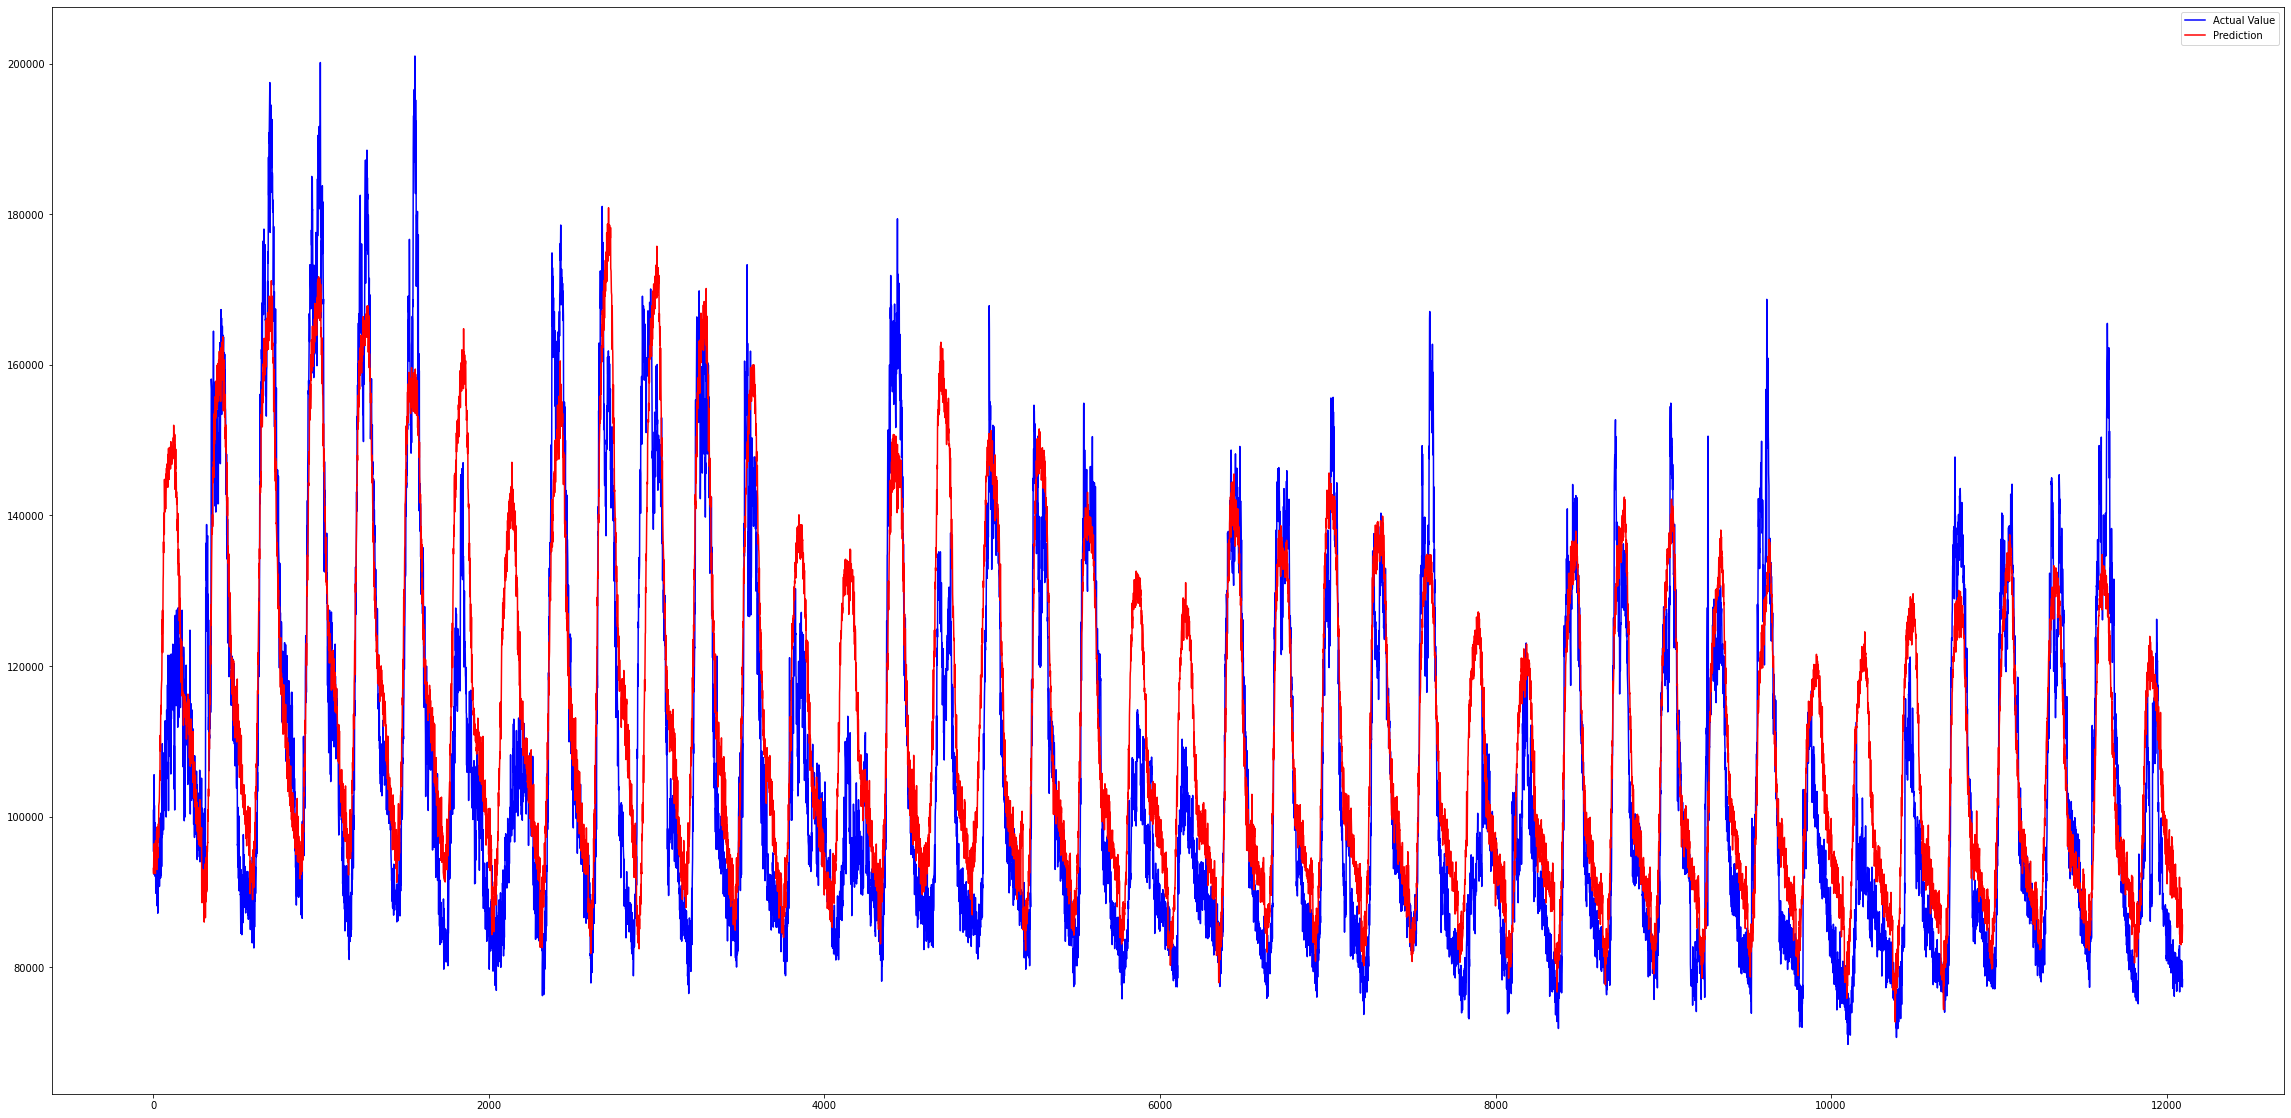

In [0]:
plt.figure(figsize=(40, 20))
plt.plot(actuals, color = 'blue')
plt.plot(forecasts, color = 'red')
plt.legend(['Actual Value', 'Prediction'])
plt.savefig('forecasts/full_testing_length/' + args.save_folder + '/forecast.png')

In [0]:
if not os.path.exists('forecasts/full_testing_length/results.csv'):
  results = po.DataFrame(columns = ['model', 'MAE', 'MSE', 'R2', 'MAPE', 'RMSE'])  
else:
  results = po.read_csv('forecasts/full_testing_length/results.csv')

In [0]:
errors = {'model': args.save_folder,
          'MAE': mean_absolute_error(y_true=y_test, y_pred=y_pred),
          'MAPE': mean_absolute_error(y_true=y_test, y_pred=y_pred)*100,
          'MSE': mean_squared_error(y_true=y_test, y_pred=y_pred),
          'RMSE': mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False),
          'R2': r2_score(y_true=y_test, y_pred=y_pred)          
          }
errors = po.Series(errors)
results = results.append(errors, ignore_index=True)

In [0]:
results

,model,MAE,MSE,R2,MAPE,RMSE
0,Dilated_CNN,0.037945,0.002629,0.732376,3.794527,0.051273
1,vanillaWaveNet_256_channels,0.046997,0.003457,0.648037,4.699682,0.058799
2,convLSTM,0.040161,0.002803,0.714712,4.016132,0.052941


In [0]:
results.to_csv('forecasts/full_testing_length/results.csv', index=False)

In [0]:
with open('forecasts/full_testing_length/' + args.save_folder + '/params.json', 'w') as f:
  f.write(json.dumps(args.__dict__))
f.close()

In [0]:
df_wave = po.read_csv('forecasts/full_testing_length/vanillaWaveNet_256_channels/full_results.csv')
df_wave.head()

,Predictions,Actual Values
0,97991.437500,100824.750417
1,91419.320312,95353.294219
2,96291.531250,100304.997865
3,92094.625000,94397.899453
4,95090.210938,105565.567786


In [0]:
df_cnn = po.read_csv('forecasts/full_testing_length/Dilated_CNN/full_results.csv')
df_cnn.head()

,Predictions,Actual Values
0,92131.953125,100824.750417
1,91359.578125,95353.294219
2,89244.835938,100304.997865
3,93425.023438,94397.899453
4,89248.132812,105565.567786


In [0]:
df_convLSTM = po.read_csv('forecasts/full_testing_length/convLSTM/full_results.csv')
df_convLSTM.head()

,Predictions,Actual Values
0,93116.671875,100824.750417
1,92430.062500,95353.294219
2,94852.414062,100304.997865
3,96159.218750,94397.899453
4,95633.328125,105565.567786


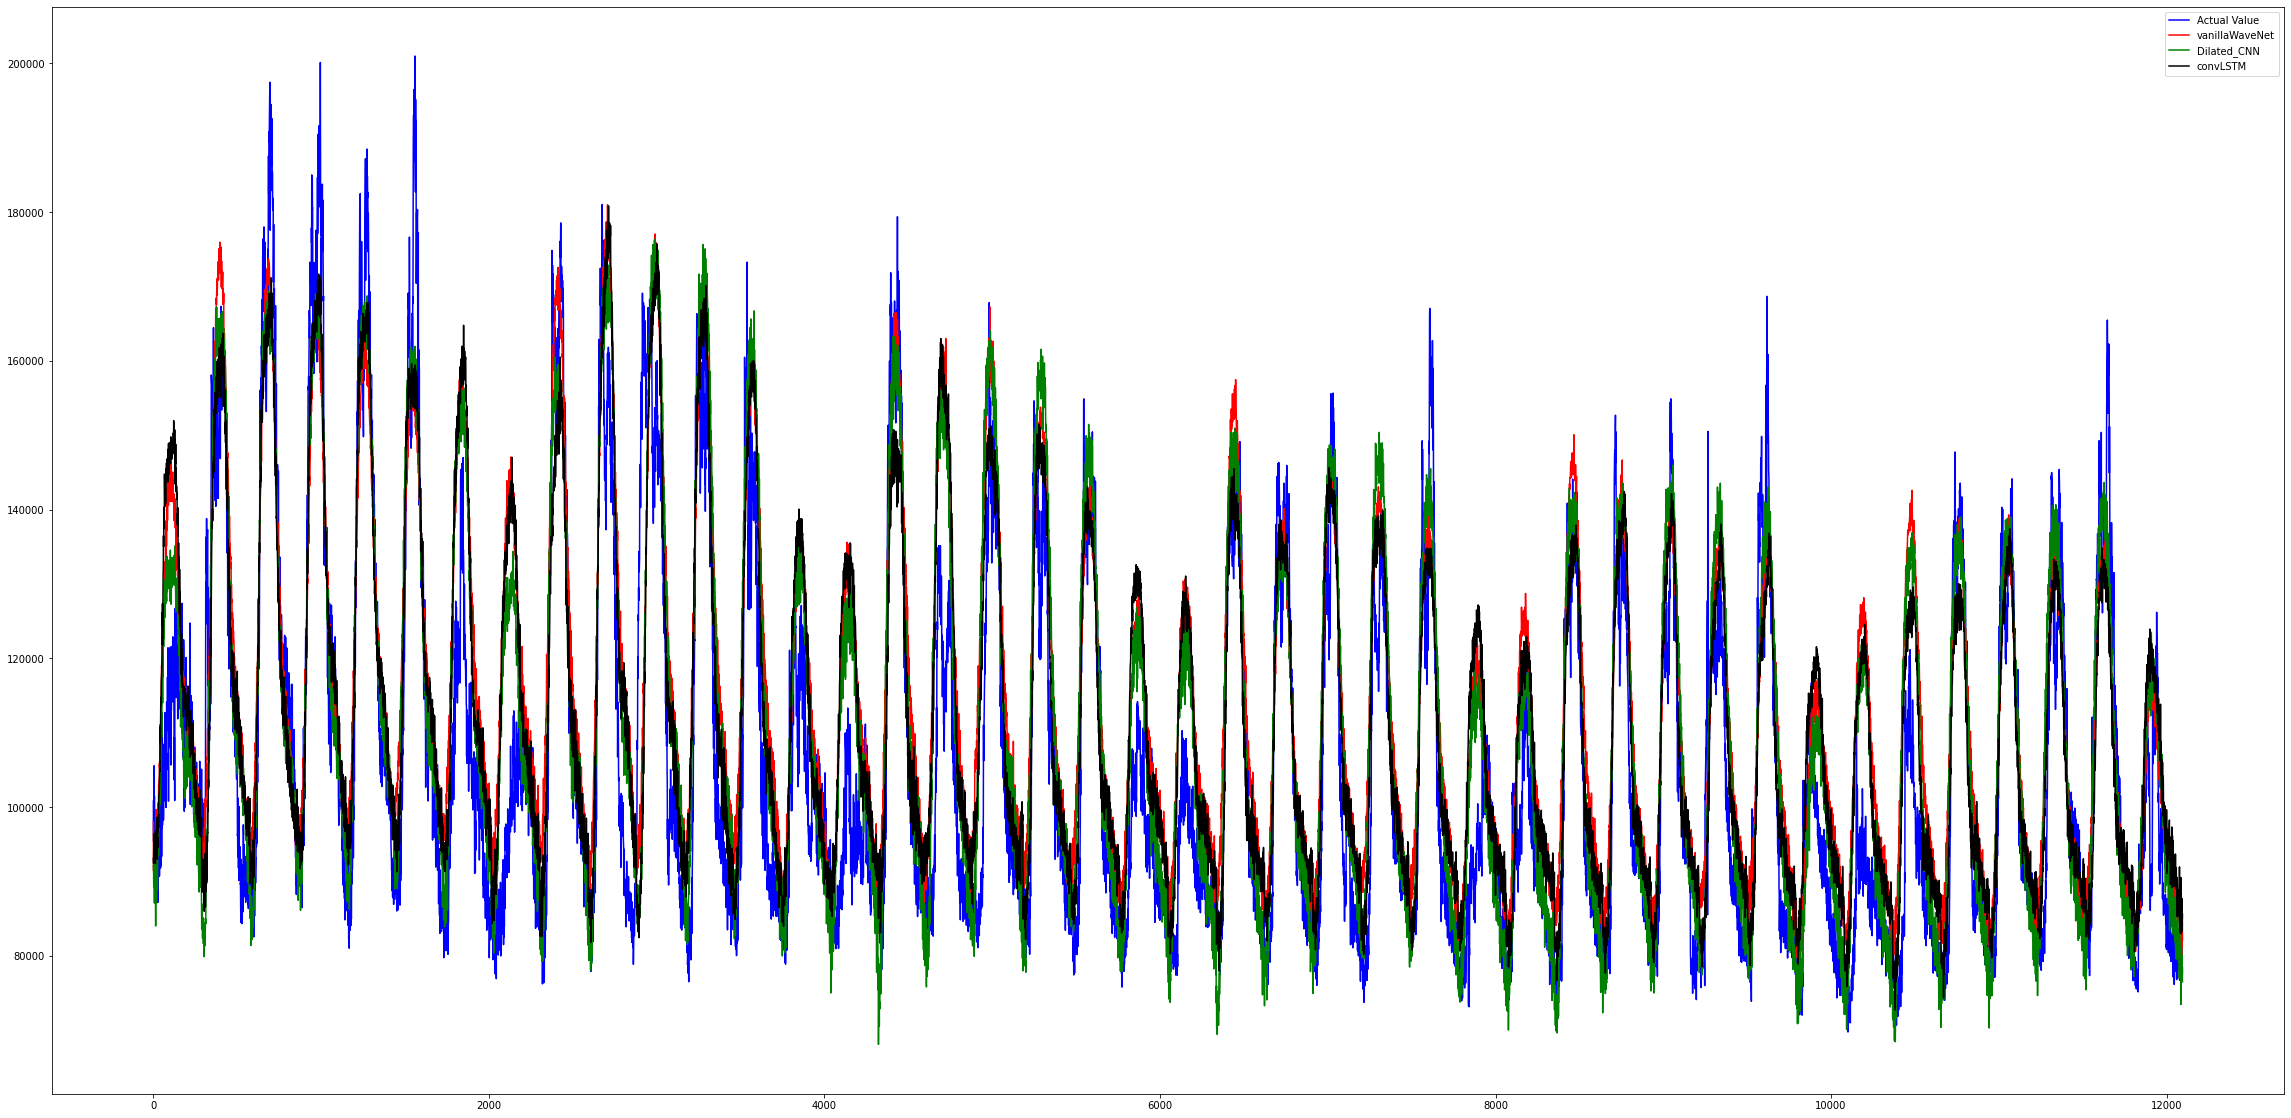

In [0]:
plt.figure(figsize=(40, 20))
plt.plot(actuals, color = 'blue')
plt.plot(df_wave['Predictions'], color = 'red')
plt.plot(df_cnn['Predictions'], color = 'green')
plt.plot(df_convLSTM['Predictions'], color = 'black')
plt.legend(['Actual Value', 'vanillaWaveNet', 'Dilated_CNN', 'convLSTM'])
plt.savefig('forecasts/full_testing_length/forecast.png')